# Simplistic attempts at an MNIST classifier: The Hello World of neural networks.

The code here roughly reproduces what's done in 3Blue1Brown's introductory videos on neural networks. 
In case you have never seen those videos: you absolutely must! They are awesome! They can be found at: https://www.3blue1brown.com/topics/neural-networks 

Classifying digits is the "Hello World" of neural networks – a moderately difficult task that can be solved reasonably well even with a simple neural network. It's also possible to train on standard computers without having to wait forever.

In [1]:
import time
import random
import os
import struct
import numpy as np
import torch
import torch.nn as nn
import ipywidgets as widgets
import PIL.Image

In [2]:
# try this if you want to train your model on the GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
%%capture
# now, the following is cool: it lets us import functions that we define in other notebooks! 
%run PyTorch.ipynb import plot
# (The drawback: we hardly ever write notebooks in a way that makes for good modules to import from; 
# specifically: the whole PyTorch notebook is run above, not only the cell that defines the plot function. 
# Calling %run can easily become slow.)
# we use capture above to avoid seeing all the output that results from executing the notebook. 

In [4]:
# this code reads a database of digits (the database is already included in the repository)
# please don't look too closely at this code, I'm not proud of it.
# minimally adapted from https://gist.github.com/akesling/5358964
def read_mnist(dataset, path="data/MNIST/raw/"):
    if dataset == "training":
        fname_img = os.path.join(path, "train-images-idx3-ubyte")
        fname_lbl = os.path.join(path, "train-labels-idx1-ubyte")
    elif dataset == "testing":
        fname_img = os.path.join(path, "t10k-images-idx3-ubyte")
        fname_lbl = os.path.join(path, "t10k-labels-idx1-ubyte")
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, "rb") as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        labels = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, "rb") as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        images = np.multiply(
            np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows*cols),
            1.0 / 255.0)

    get_instance = lambda idx: (labels[idx], images[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(labels)):
        yield get_instance(i)
        
training = [(lbl, img) for (lbl, img) in read_mnist("training")]
testing = [(lbl, img) for (lbl, img) in read_mnist("testing")]

In [5]:
# print some examples (pairs of target number and image)
import io
for i in range(10):
    buffer = io.BytesIO()
    PIL.Image.fromarray((256*training[i][1]).reshape(28, 28)).convert('L').save(buffer, format="PNG")
    display(training[i][0], widgets.Image(value=buffer.getvalue(),width=28,height=28))

5

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

0

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

4

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

9

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

2

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

3

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

1

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

4

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

# A simple neural network for MNIST
In MNIST we have grayscale images of digits, 28x28 pixels in size (as shown above). 
We will define a network with two inner (hidden) layers, each with 16 neurons, and an output layer with 10 neurons, one per digit.
Let's go!

In [6]:
HIDDEN_DIM1 = 16
HIDDEN_DIM2 = 16

In [7]:
class MNISTClassify(nn.Module):
    def __init__(self):
        super(MNISTClassify, self).__init__()
        input_size = 28 * 28
        self.W1 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(input_size, HIDDEN_DIM1)))
        self.b1 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_DIM1)))
        self.W2 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_DIM1, HIDDEN_DIM2)))
        self.b2 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, HIDDEN_DIM2)))
        self.W3 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(HIDDEN_DIM2, 10)))
        self.b3 = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, 10)))
        
    def forward(self, x):
        # erste innere Schicht:
        h1 = nn.functional.sigmoid(x @ self.W1 + self.b1)
        # zweite innere Schicht:
        h2 = nn.functional.sigmoid(h1 @ self.W2 + self.b2)
        # Ergebnisschicht:
        activation = nn.functional.log_softmax(h2 @ self.W3 + self.b3, dim=1)
        return activation.view(10)

What's new here? 

We're not computing the outputs of individual neurons! Instead, we compute the weighted sum for all output neurons from all weighted input neurons in one matrix multiplication (which uses the ```@``` operator). We then add a bias *vector* (instead of just one bias value). The agreement is that sigmoid called on a vector yields the vector of the sigmoid operation performed on each individual value in the vector.

Matrix operations really condense the computations needed for a full layer to <tt>a<sub>out</sub> = &sigma;(a<sub>in</sub> &middot; W + b)</tt>. Note again, that operator overloading makes this concise form possible. 

What's important to note is that we need to make sure that weight matrices (and bias vectors) are of the right sizes, check the sizes in the constructor.

Also, note that we initialize the parameters in a certain way – one that was vital discovery in making deep learning actually work in practice.

# The training loop.
The training is actually quite similar to what we did in the previous exercise. 
we over and over repeat the following:
* have the network produce some output (**new:** there's now input involved!)
* compute the desired output (**new:** this also comes from data!)
* compute the model loss as the squared error between target and estimate
* compute the gradients of the error wrt. all parameters
* adjust errors a little bit in the right direction.

We perform this repeatedly and every time with a different image. Once we're through with every image, we repeat, for a total of 5 repetitions (each repetition is called an *epoch*). 
After every epoch, we **test** the model on some validation data. In that way, we have a better chance at assessing the real-world performance of the model on new data, as compared to data that has been seen in training.

Epoch 1 starting
Held out accuracy 0.9051 (7646.108196074007 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 943   0     7     2     1     6     7     3     7     5     
P1 0     1098  9     4     3     6     3     24    10    8     
P2 4     8     896   19    3     10    2     25    11    3     
P3 2     4     20    899   0     43    3     5     24    11    
P4 1     2     18    1     903   12    8     12    15    44    
P5 6     2     5     26    0     739   21    1     29    7     
P6 16    6     15    6     18    22    914   3     15    2     
P7 1     0     18    14    1     16    0     924   11    15    
P8 7     14    35    27    4     26    0     1     835   14    
P9 0     1     9     12    49    12    0     30    17    900   
instances per sec: 1231.6554861965649
Epoch 2 starting
Held out accuracy 0.9087 (7667.946758982493 instances/sec)
   T0    T1    T2    T3    T4    T5    T6    T7    T8    T9    
P0 956   0     11    5     1     10    17 

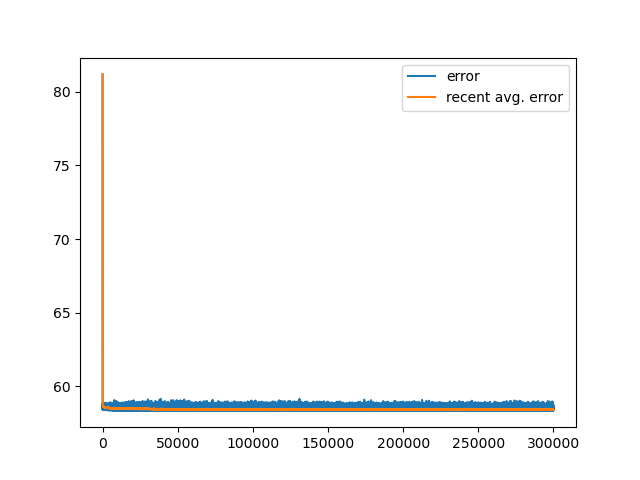

In [8]:
%matplotlib widget
classify = MNISTClassify().float().to(device)
learning_rate = 0.01
optimizer = torch.optim.SGD(classify.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(classify.parameters())
#loss = nn.CrossEntropyLoss
dev_time = 0.0
plot_data = defaultdict(lambda : [])

start = time.time()
for epoch in range(5):
    print(("Epoch {} starting".format(epoch+1)))
    random.shuffle(training)
    # train model:
    recent_errors = []
    classify.train(True)
    for cls, img in training:
        optimizer.zero_grad()
        # Bild als Eingabe aufbereiten
        x = torch.tensor(img).float().to(device)
        # Outputaktivierung berechnen
        output = classify(x)
        # "idealen" Output (überall 0, nur gewählte Klasse ist 1)
        target = torch.zeros(10).long().to(device)
        target[cls] = 1.0
        # Kostenfunktion berechnen
        loss = torch.sum((output - target) ** 2)
        #loss  = nn.functional.nll_loss(output, torch.tensor(cls).long().to(device))
        plot_data["error"].append(loss.item())
        recent_errors.append(loss.item())
        if len(recent_errors) > 100:
            recent_errors = recent_errors[-100:-1] # keep only the last part
        plot_data["recent avg. error"].append(sum(recent_errors) / len(recent_errors))
        # Kosten den einzelnen Parametern zuordnen
        loss.backward()
        # Parameter entsprechend anpassen
        optimizer.step()
    classify.train(False)
    
    # test performance of classifier:
    confusion = [[0 for _ in range(10)] for _ in range(10)]
    correct = 0
    dev_start = time.time()
    for cls, img in testing:
        x = torch.tensor(img).float().to(device)
        output = classify(x)
        prediction = int(torch.topk(output, 1)[1].item())
        if cls == prediction:
            correct += 1
        confusion[prediction][cls] += 1
    dev_end = time.time()
    acc = float(correct) / len(testing)
    dev_time += dev_end - dev_start
    print(("Held out accuracy {} ({} instances/sec)".format(
        acc, len(testing) / (dev_end - dev_start))))
    print('   ' + ''.join(('T'+str(x)).ljust(6) for x in range(10)))
    for p, row in enumerate(confusion):
        s = 'P' + str(p) + ' '
        s += ''.join(str(col).ljust(6) for col in row)
        print(s)

    end = time.time()
    print(("instances per sec: {}".format(
                ((epoch+1) * len(training)) / (end - start - dev_time))))

plot(plot_data)

In [19]:
# This cell provides an alternative to the above implementation. It should do precisely the same but defers the actual implementation to 
# sub-modules (nn.Linear).

class MNISTClassify(nn.Module):
    """the same but using the built-in modules for densely connected feed-forward layers"""
    def __init__(self):
        super(MNISTClassify, self).__init__()
        input_size = 28 * 28
        self.l1 = nn.Linear(input_size, HIDDEN_DIM1)
        self.l2 = nn.Linear(HIDDEN_DIM1, HIDDEN_DIM2)
        self.l3 = nn.Linear(HIDDEN_DIM2, 10)

    def forward(self, x):
        return nn.functional.log_softmax(self.l3(nn.functional.sigmoid(self.l2(nn.functional.sigmoid(self.l1(x))))), dim=0)


In [12]:
import torch.nn.functional as F
class MNISTClassify(nn.Module):
    """works much better with CNNs.
    shamefully stolen/borrowed from https://github.com/mbjoseph/pytorch-mnist/blob/master/cnn-mnist.ipynb
    """
    def __init__(self):
        super(MNISTClassify, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x, isTrain=False):
        x = x.reshape((1,1,28,28))
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.num_flat_features(x))
        x = F.log_softmax(self.fc2(x), dim=-1)
        return x.view((10))
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [14]:
import torch.nn.functional as F
class MNISTClassify(nn.Module):
    """works much better with CNNs.
    shamefully stolen/borrowed from https://github.com/mbjoseph/pytorch-mnist/blob/master/cnn-mnist.ipynb
    """
    def __init__(self):
        super(MNISTClassify, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x, isTrain=False):
        x = x.reshape((1,1,28,28))
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=-1)
        return x.view((10))
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features